In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from tqdm import tqdm

import numpy as np
from time import process_time

import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from plot_lib import plot_data, plot_model, plot_results, set_default

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
set_default()

In [3]:
# Constants
DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"
# DEVICE = "cpu"
DATADIR = "/Users/mghifary/Work/Code/AI/data"
BATCH_SIZE = 128

EPOCHS = 2

In [4]:
# Define image transformation
train_transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

inference_transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

In [5]:
# Download training data from open datasets.
train_data = datasets.FashionMNIST(
    root=DATADIR,
    train=True,
    download=True,
    transform=train_transform
)

In [6]:
test_data = datasets.FashionMNIST(
    root=DATADIR,
    train=False,
    download=True,
    transform=inference_transform
)

In [7]:
# Create data loaders
train_dataloader = DataLoader(
    train_data, 
    batch_size=BATCH_SIZE,
    shuffle=True,
)
test_dataloader = DataLoader(
    test_data, 
    batch_size=BATCH_SIZE,
    shuffle=False,
)

In [8]:
for X, y in train_dataloader:
    [_, c, dx1, dx2] = X.shape
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape}, {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([128, 1, 28, 28])
Shape of y: torch.Size([128]), torch.int64


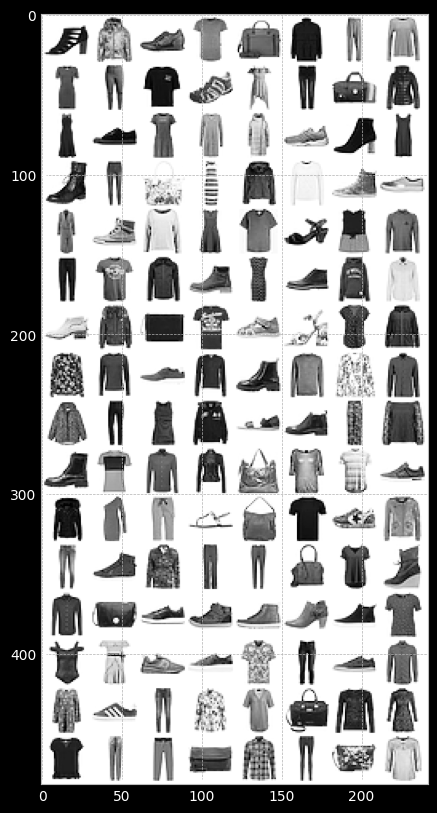

In [9]:
# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

In [10]:
# Define standard convnet
class ConvNet(nn.Module):
    def __init__(self, ch, dx1, dx2, num_classes):
        super(ConvNet, self).__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(ch, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),   
        )

        self.ff_block = nn.Sequential(
            nn.Linear(64 * (dx1 // 4) * (dx2 // 4), 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )


    def forward(self, x):
        y = self.conv_block(x)
        logits = self.ff_block(y)
        return logits

In [11]:
model = ConvNet(c, dx1, dx2, 10)
model = model.to(DEVICE)
print(model)

ConvNet(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (ff_block): Sequential(
    (0): Linear(in_features=3136, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [12]:
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [13]:
# Define training and inference methods
def train(model, dataloader, device="cpu"):
    print(f"Training -- using device {device}")
    train_time = 0.0
    losses = 0.
    with tqdm(dataloader, unit="batch") as tepoch:
        for (X, y) in tepoch:
            start_t = process_time()
            X, y = X.to(DEVICE), y.to(DEVICE)
            # print(f"X shape: {X.shape}")
            # Compute prediction error
            logits = model(X)

            # Loss function
            loss = F.cross_entropy(logits, y)
            batch_size = X.shape[0]
            losses += (loss.item() / batch_size)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            elapsed_time = process_time() - start_t
            train_time += elapsed_time

            # print(f"[Batch-{b}] loss: {loss.item()}, training time (secs): {train_time}")

            tepoch.set_postfix({
                'loss': loss.item(),
                'time(secs)': train_time
            })
        # end for
            
    num_data = len(dataloader.dataset)
    losses /= num_data
            
    return losses, train_time

def evaluate(model, dataloader, device="cpu"):
    print(f"Evaluation -- using device {device}")

    model.eval()
    eval_time = 0.0
    losses = 0.0
    correct = 0
    
    with tqdm(dataloader, unit="batch") as tepoch:
        for (X, y) in tepoch:
            start_t = process_time()
            X, y = X.to(device), y.to(device)
            
            # Compute loss
            with torch.no_grad():
                logits = model(X)
            loss = F.cross_entropy(logits, y)
            batch_size = X.shape[0]
            losses += (loss.item() / batch_size)

            # Compute correct predictions
            pred = torch.argmax(logits, axis=1)
            correct += torch.sum(pred == y)

            elapsed_time = process_time() - start_t
            eval_time += elapsed_time


            tepoch.set_postfix({
                'loss': loss.item(),
                'time(secs)': eval_time
            })
        # end for
            
    model.train()

    num_data = len(dataloader.dataset)
    accuracy = correct.item() / num_data
    return losses, accuracy, eval_time


In [14]:
# losses, train_time = train(model, train_dataloader, device=DEVICE)


In [15]:
# train_loss, train_acc, _ = evaluate(model, train_dataloader, device=DEVICE)
# test_loss, test_acc, _ = evaluate(model, test_dataloader, device=DEVICE)

# print(f"[Train] loss: {train_loss}, accuracy: {train_acc}")
# print(f"[Test] loss: {test_loss}, accuracy: {test_acc}")


In [16]:

for epoch in range(EPOCHS):
    losses, train_time = train(model, train_dataloader, device=DEVICE)

    train_loss, train_acc, _ = evaluate(model, train_dataloader, device=DEVICE)
    test_loss, test_acc, _ = evaluate(model, test_dataloader, device=DEVICE)

    print(f"[Epoch {epoch + 1} / {EPOCHS}, training time: {train_time:.2f} secs] (Train) loss: {train_loss:.4f}, accuracy: {train_acc:.4f} (Test) loss: {test_loss:.4f}, accuracy: {test_acc:.4f}")


Training -- using device mps


100%|██████████| 469/469 [00:10<00:00, 46.74batch/s, loss=0.546, time(secs)=3.69]


Evaluation -- using device mps


100%|██████████| 469/469 [00:04<00:00, 99.84batch/s, loss=0.427, time(secs)=0.95]  


Evaluation -- using device mps


100%|██████████| 79/79 [00:00<00:00, 89.36batch/s, loss=0.366, time(secs)=0.203] 


[Epoch 1 / 2, training time: 3.69 secs] (Train) loss: 1.5946, accuracy: 0.8467 (Test) loss: 0.2997, accuracy: 0.8373
Training -- using device mps


100%|██████████| 469/469 [00:10<00:00, 46.48batch/s, loss=0.394, time(secs)=3.39] 


Evaluation -- using device mps


100%|██████████| 469/469 [00:04<00:00, 100.17batch/s, loss=0.249, time(secs)=0.92] 


Evaluation -- using device mps


100%|██████████| 79/79 [00:00<00:00, 97.85batch/s, loss=0.289, time(secs)=0.154]  

[Epoch 2 / 2, training time: 3.39 secs] (Train) loss: 1.3896, accuracy: 0.8605 (Test) loss: 0.2645, accuracy: 0.8488
